# Une régression logistique pour prédire l'achat d'une voiture

Charger le fichier Social_Network_Ads.csv et regarder ce qu'il contient.

## Import des libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Import des données

In [6]:
data = pd.read_csv('Social_Network_Ads.csv')
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


## Visualisation des données

Regardez via des graphiques de votre choix les effets des différentes variables sur l'achat d'une voiture.

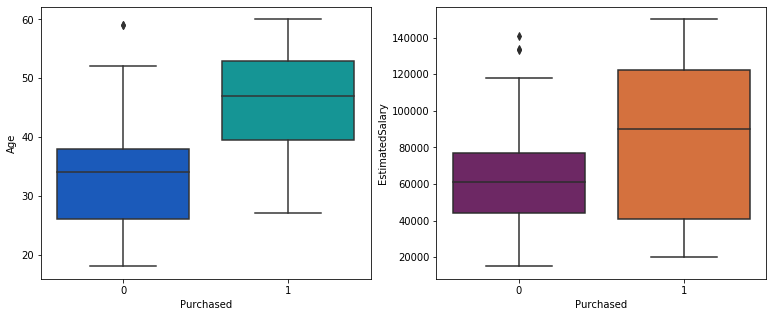

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,5))
sns.boxplot(x='Purchased',y='Age', data=data, palette = 'winter', ax=ax1)
sns.boxplot(x='Purchased',y='EstimatedSalary', palette = 'inferno', data=data, ax=ax2);

## Création de X et y (on ne prend que l'age et le salaire estimé dans X)

Dans un premier temps on n'utilisera dans notre modèle que Age et EstimatedSalary comme variables explicatives.

In [35]:
X = data[['Age','EstimatedSalary']]
y = data['Purchased']

## Création d'un Training set et d'un Test set

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 64)

## Entraînement d'une régression logistique sur le Training set

In [37]:
# Entraînement du modèle
from sklearn.linear_model import LogisticRegression
reglog = LogisticRegression(solver='liblinear', random_state = 64)
reglog.fit(X_train, y_train)

# Prédire les classes du Test set
y_pred = reglog.predict(X_test)

# Créer et afficher la matrice de confusion
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['prédit ' + str(_) for _ in reglog.classes_])
cm.index = ['vrai ' + str(_) for _ in reglog.classes_]
cm

,prédit 0,prédit 1
vrai 0,66,0
vrai 1,34,0


In [38]:
coef = pd.DataFrame(np.concatenate([reglog.intercept_.reshape(-1,1), reglog.coef_],axis=1), index = ["Coefs"],columns = ["const"]+list(X.columns)).T
coef["OR"] = np.exp(coef.Coefs)
coef

,Coefs,OR
const,-2.060223e-03,0.997942
Age,-3.878139e-03,0.996129
EstimatedSalary,-6.621093e-07,0.999999


In [39]:
import statsmodels.api as sm
X = sm.add_constant(X)
reglog2 = sm.Logit(y, X)
res = reglog2.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.346314
         Iterations 8


/home/elka/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Purchased   No. Observations:                  400
Model:                          Logit   Df Residuals:                      397
Method:                           MLE   Df Model:                            2
Date:                Wed, 29 Jan 2020   Pseudo R-squ.:                  0.4688
Time:                        13:44:43   Log-Likelihood:                -138.53
converged:                       True   LL-Null:                       -260.79
Covariance Type:            nonrobust   LLR p-value:                 7.995e-54
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -12.4340      1.300     -9.566      0.000     -14.982      -9.886
Age                 0.2335      0.026      9.013      0.000       0.183       0.284
EstimatedSalary   3.59e-05   5.43e-06      6.613      0.000    2.53e-05    4.65e-05
===================================================================================
"""

Il y a visiblement un problème...d'où peut-il venir ? Une idée d'une solution ? Le *features scaling*...

Essayer les 2 méthodes de *features scaling* : la normalisation et la standardisation et réentrainer le modèle à chaque fois pour voir les résultats.

#### Standardisation des features avec StandardScaler

In [21]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Normalisation des features avec MinMaxScaler

In [26]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

## Visualisation des classes sur un graphique

Essayer d'obtenir le graphique suivant. C'est pas facile mais possible ! Faites 2 graphique séparés : un pour les données du training set et un pour les données du test set

<table><tr>
<td> <img src="viz.png"/> </td>
<td> <img src="viz2.png"/> </td>
</tr></table>

Vous pourrez utiliser :
- np.meshgrid
- plt.contourf
- ListedColormap
- plt.pcolormesh

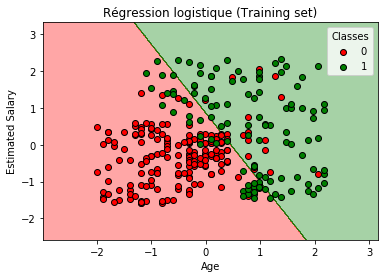

In [57]:
# Visualisation des résultats sur le Training set
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train

X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))

Y = reglog.predict(np.array([X1.ravel(), X2.ravel()]).T)
Y = Y.reshape(X1.shape)

plt.contourf(X1, X2, Y, alpha = 0.35, cmap = ListedColormap(('red', 'green')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

plt.scatter(X_set[y_set == 0, 0], X_set[y_set == 0, 1],c ='red', edgecolors='k', label = 0)
plt.scatter(X_set[y_set == 1, 0], X_set[y_set == 1, 1],c ='green', edgecolors='k', label = 1)
    
plt.title('Régression logistique (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend(loc="upper right", title="Classes")

plt.show()

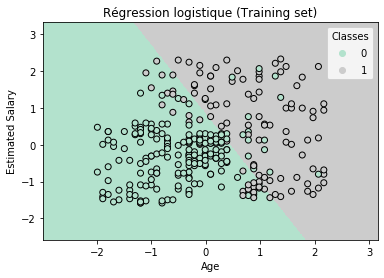

In [56]:
# Visualisation des résultats sur le Training set
X_set, y_set = X_train, y_train

X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

Y = reglog.predict(np.array([X1.ravel(), X2.ravel()]).T)
Y = Y.reshape(X1.shape)

plt.pcolormesh(X1, X2, Y, cmap=plt.cm.Pastel2)
scatter = plt.scatter(X_set[:, 0], X_set[:, 1], c=y_set, edgecolors='k', cmap=plt.cm.Pastel2)
    
plt.title('Régression logistique (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')

# pour ajouter une légende à partir du scatter
plt.legend(*scatter.legend_elements(),loc="upper right", title="Classes")
plt.show()

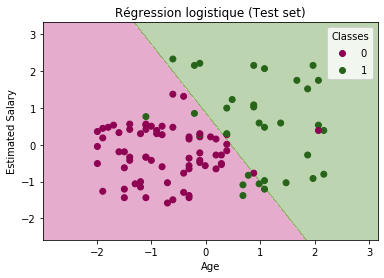

In [62]:
# Visualisation des résultats sur le Test set
X_set, y_set = X_test, y_test

X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))

plt.contourf(X1, X2, reglog.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.35, cmap = plt.cm.PiYG)

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

scatter = plt.scatter(X_set[:, 0], X_set[:, 1], c = y_set, cmap = plt.cm.PiYG)
    
plt.title('Régression logistique (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")

plt.show()

## Un seconde régression logistique

Entraîner une nouvelle régression logistique en incluant cette fois la variable Gender

## Comparaison des 2 régressions logistiques

Comparer les 2 modèles pour déterminer lequel est le "meilleur".